In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import torchaudio

random.seed(0)
np.random.seed(0)

In [2]:
!nvidia-smi

Fri Aug  4 18:38:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
| 37%   59C    P3             142W / 350W |    973MiB / 24576MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust          664
fear             705
joy            19002
neutral        14429
sadness         2936
surprise        5062

In [6]:
anger = go_emotions[go_emotions["grouped_label"] == "anger"].sample(5000, replace=False, random_state=0)
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True, random_state=0)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True, random_state=0)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False, random_state=0)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(2000, replace=False, random_state=0)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True, random_state=0)

In [7]:
#go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
#go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
#go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, disgust, fear, sadness])
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust         4664
fear            4705
joy            19002
neutral        14429
sadness         4936
surprise        5062

In [8]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [9]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [10]:
pd.concat([train_audio,test_audio]).groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise   592

In [11]:
audio_datasets = pd.concat([train_audio,test_audio]).reset_index(drop=True)

In [12]:
surprise = audio_datasets[audio_datasets["label"] == "surprise"].sample(2000, replace=True, random_state=0)
audio_datasets = audio_datasets[audio_datasets["label"] != "surprise"]
audio_datasets = pd.concat([audio_datasets, surprise]).reset_index(drop=True)
#audio_datasets

In [13]:
audio_datasets.groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise  2000

## Load Meld and IEMOCAP

In [14]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

text     label  \
0      The only one I know still love his parents. [B...       joy   
1      The only one I know still love his parents. Ye...   neutral   
2      Oh it's not bad thing it's good thing. You kno...       joy   
3      You know it's nice here, the air is sweet. You...   sadness   
4      You're not sorry you came? Not sorry, no.  I c...   sadness   
...                                                  ...       ...   
13723  That would be no. Come on. It doesn't taste ba...   neutral   
13724  Come on. It doesn't taste bad. Yeah, it's kind...       joy   
13725  Yeah, it's kinda sweet, sorta like, uh... Cant...   neutral   
13726  Cantaloupe juice. Exactly. [BFR] You've tasted...  surprise   
13727  Exactly. You've tasted it? You've tasted it. [...   neutral   

                                                    path  
0      /home/vmachado/Documents/multimodal-datasets/I...  
1      /home/vmachado/Documents/multimodal-datasets/I...  
2      /home/vmachado/Documents/multimodal-datasets/I...  
3      /home/vmachado/Documents/multimodal-datasets/I...  
4      /home/vmachado/Documents/multimodal-datasets/I...  
...                                                  ...  
13723  /home/vmachado/Documents/multimodal-datasets/M...  
13724  /home/vmachado/Documents/multimodal-datasets/M...  
13725  /home/vmachado/Documents/multimodal-datasets/M...  
13726  /home/vmachado/Documents/multimodal-datasets/M...  
13727  /home/vmachado/Documents/multimodal-datasets/M...  

[13728 rows x 3 columns]

In [15]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path  
0     /home/vmachado/Documents/multimodal-datasets/I...  
1     /home/vmachado/Documents/multimodal-datasets/I...  
2     /home/vmachado/Documents/multimodal-datasets/I...  
3     /home/vmachado/Documents/multimodal-datasets/I...  
4     /home/vmachado/Documents/multimodal-datasets/I...  
...                                                 ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...  
3847  /home/vmachado/Documents/multimodal-datasets/M...  
3848  /home/vmachado/Documents/multimodal-datasets/M...  
3849  /home/vmachado/Documents/multimodal-datasets/M...  
3850  /home/vmachado/Documents/multimodal-datasets/M...  

[3851 rows x 3 columns]

In [16]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path   source  
0     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
1     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
2     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
3     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
4     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
...                                                 ...      ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3847  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3848  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3849  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3850  /home/vmachado/Documents/multimodal-datasets/M...     meld  

[3851 rows x 4 columns]

In [17]:
test_df_erc.groupby("source").count()

text  label  path
source                    
iemocap  1241   1241  1241
meld     2610   2610  2610

## Join datasets

In [18]:
train_df_erc.groupby("label").count()

text  path
label               
anger     1954  1954
disgust    258   258
fear       266   266
joy       2783  2783
neutral   5804  5804
sadness   1451  1451
surprise  1212  1212

In [19]:
ang = train_df_erc[train_df_erc["label"] == "anger"].sample(3000, replace=True, random_state=0)
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(4700, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(4700, replace=True, random_state=0)
joy = train_df_erc[train_df_erc["label"] == "joy"].sample(2300, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(3500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(3800, replace=True, random_state=0)

#excited = train_df_erc[train_df_erc["label"] == "excited"].sample(4300, replace=True, random_state=0)
#frustration = train_df_erc[train_df_erc["label"] == "frustration"].sample(3600, replace=True, random_state=0)

In [20]:
#train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness, excited, frustration]).reset_index(drop=True)
train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness]).reset_index(drop=True)

In [21]:
#train_df_erc_resampled = train_df_erc

In [22]:
train_df_erc_resampled.groupby("label").count()

text  path
label               
anger     4954  4954
disgust   4958  4958
fear      4966  4966
joy       5083  5083
neutral   5804  5804
sadness   4951  4951
surprise  5012  5012

## VoxPopuli + VoxCeleb

In [23]:
df_vox = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]]
df_vox

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

In [24]:
df_ls = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]] #pd.read_csv("df_ls.csv")
df_ls

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

## Join all datasets

In [25]:
#df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
#df_train = pd.concat([audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled,train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), train_df_erc_resampled, df_ls, audio_datasets]).reset_index(drop=True)
df_train

text     label  \
0       My favourite food is anything I didn't have to...   neutral   
1       Now if he does off himself, everyone will thin...   neutral   
2                          WHY THE FUCK IS BAYLESS ISOING     anger   
3                             To make her feel threatened      fear   
4                                  Dirty Southern Wankers     anger   
...                                                   ...       ...   
114816                                                NaN  surprise   
114817                                                NaN  surprise   
114818                                                NaN  surprise   
114819                                                NaN  surprise   
114820                                                NaN  surprise   

                                                  path sentiment_label  
0                                                 None             NaN  
1                                                 None             NaN  
2                                                 None             NaN  
3                                                 None             NaN  
4                                                 None             NaN  
...                                                ...             ...  
114816  ./audio/audio_emo/tess.woman.surprised.351.wav             NaN  
114817   ./audio/audio_emo/ravdass.man.surprise.63.wav             NaN  
114818   ./audio/audio_emo/tess.woman.surprised.26.wav             NaN  
114819   ./audio/audio_emo/tess.woman.surprised.67.wav             NaN  
114820   ./audio/audio_emo/ravdass.man.surprise.52.wav             NaN  

[114821 rows x 4 columns]

In [26]:
import math

def label_to_sentiment(x):
    if x == None:
        return x
    if x in ["joy", "surprise", "excited"]:
        return "Positive"
    elif x in ["fear", "anger", "disgust", "sadness", "frustration"]:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_train["sentiment_label"] = df_train["label"].apply(label_to_sentiment)

In [28]:
df_train

text     label  \
0       My favourite food is anything I didn't have to...   neutral   
1       Now if he does off himself, everyone will thin...   neutral   
2                          WHY THE FUCK IS BAYLESS ISOING     anger   
3                             To make her feel threatened      fear   
4                                  Dirty Southern Wankers     anger   
...                                                   ...       ...   
114816                                                NaN  surprise   
114817                                                NaN  surprise   
114818                                                NaN  surprise   
114819                                                NaN  surprise   
114820                                                NaN  surprise   

                                                  path sentiment_label  
0                                                 None         Neutral  
1                                                 None         Neutral  
2                                                 None        Negative  
3                                                 None        Negative  
4                                                 None        Negative  
...                                                ...             ...  
114816  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
114817   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
114818   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
114819   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
114820   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[114821 rows x 4 columns]

In [29]:
df_train["sentiment_label"].value_counts()

Negative    47625
Positive    38214
Neutral     28982
Name: sentiment_label, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train['label'].unique())

lab_encoder_senti = LabelEncoder()
lab_encoder_senti.fit(df_train['sentiment_label'].unique())

LabelEncoder()

In [31]:
len(df_train)

114821

In [32]:
len(test_df_erc)

3851

In [33]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [34]:
gc.collect()

0

In [35]:
import numpy as np
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [36]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

global PREVIOUS_LR
PREVIOUS_LR = -9999
def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    global PREVIOUS_LR
    lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
    #return lr
    if lr <= 3e-4:
        PREVIOUS_LR = lr
        return lr
    else:
        #lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        while lr >= PREVIOUS_LR:
            step += 1.
            lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        PREVIOUS_LR = lr
        return lr

In [37]:
from src.modeling.speech_encoder import *

dim_embed = 768
N_VECTORS = 128
MAX_LEN = 48

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=6, 
    max_length=MAX_LEN, 
    nheads=6,
    dropout=0.2
)

#audio_encoder = torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_best/audio_encoder.bin')
#audio_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_pre_trained_reformed_5_FIM_6_layer_continue/audio_best.bin'))

In [38]:
from src.modeling.text_encoder import *

#MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
#MODEL_NAME = 'sentence-transformers/all-MiniLM-L12-v2'
#text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]'])
#text_encoder.load_state_dict(torch.load('/home/vmachado/Documents/c4ai_clip_audio_text/text_encoder_only_meld/dabest_text.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/best_text_encoder.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/pytorch_model_AudioTextCLIP_epoch_22.bin'))

In [39]:
#for param in list(text_encoder.parameters()):
#    param.requires_grad = True
    
#for idx_l, l in enumerate(text_encoder.encoder.encoder.layer):
#    if idx_l >= 11:
#        for param in list(l.parameters()):
#            param.requires_grad = True

In [40]:
df_train

text     label  \
0       My favourite food is anything I didn't have to...   neutral   
1       Now if he does off himself, everyone will thin...   neutral   
2                          WHY THE FUCK IS BAYLESS ISOING     anger   
3                             To make her feel threatened      fear   
4                                  Dirty Southern Wankers     anger   
...                                                   ...       ...   
114816                                                NaN  surprise   
114817                                                NaN  surprise   
114818                                                NaN  surprise   
114819                                                NaN  surprise   
114820                                                NaN  surprise   

                                                  path sentiment_label  
0                                                 None         Neutral  
1                                                 None         Neutral  
2                                                 None        Negative  
3                                                 None        Negative  
4                                                 None        Negative  
...                                                ...             ...  
114816  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
114817   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
114818   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
114819   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
114820   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[114821 rows x 4 columns]

In [41]:
list(df_train[~df_train["path"].isna()]["path"])

['/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M000.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F003.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M002.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F004.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F005.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F

In [42]:
from src.utils.speech_processing import *
from tqdm import tqdm
audio_tokenizer = AudioEncoderMFCCHUTokenizer(max_length=MAX_LEN, cache_path='/home/vmachado/Documents/c4ai_clip_audio_text/speech_features_500ms/')
#_, lens = audio_tokenizer.cache_dataset(paths=list(df_train[~df_train["path"].isna()].sample(frac=0.25, random_state=0)["path"]))


In [43]:
"""
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2048, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

mean = None
std = None

for e in range(10):
    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if len(batch_indices[0]) < 2048:
            continue
        batch = df_train.iloc[batch_indices[0]]
        x, lens = audio_tokenizer.cache_dataset(paths=list(batch[~batch["path"].isna()]["path"]))
        if i == 0 and e == 0:
            mean = x.mean(dim=0)
            std = x.std(dim=0)
        else:
            mean_bfr = mean
            mean = 0.9 * mean + 0.1 * x.mean(dim=0)
            print(np.abs(mean - mean_bfr).sum())
            std = 0.9 * std + 0.1 * x.std(dim=0)
    
"""

'\ntrain_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))\ntrain_loader = torch.utils.data.DataLoader(train_ds, batch_size=2048, shuffle=True)\n\ntest_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))\ntest_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)\n\nmean = None\nstd = None\n\nfor e in range(10):\n    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):\n        if len(batch_indices[0]) < 2048:\n            continue\n        batch = df_train.iloc[batch_indices[0]]\n        x, lens = audio_tokenizer.cache_dataset(paths=list(batch[~batch["path"].isna()]["path"]))\n        if i == 0 and e == 0:\n            mean = x.mean(dim=0)\n            std = x.std(dim=0)\n        else:\n            mean_bfr = mean\n            mean = 0.9 * mean + 0.1 * x.mean(dim=0)\n            print(np.abs(mean - mean_bfr).sum())\n            std = 0.9 * std + 0.1 * x.std(dim=0)\n    \n'

In [44]:
mean = torch.tensor([-7.4700e+02,  6.1580e+00, -1.6141e+02,  2.4464e+01, -1.7640e+02,
        -5.8843e+01, -1.9218e+02, -7.5818e+01, -1.2378e+02, -3.6036e+01,
        -1.0406e+02, -2.7860e+01, -7.1468e+01,  2.2020e-01,  3.1072e-01,
         2.7268e-01,  2.3750e-01,  1.9707e-01,  1.7588e-01,  1.5647e-01,
         1.4560e-01,  1.3006e-01,  1.1757e-01,  1.0836e-01,  1.0262e-01,
         9.1613e-02,  8.5846e-02,  7.9762e-02,  7.5073e-02,  6.8178e-02,
         6.3719e-02,  5.7517e-02,  5.4928e-02,  4.9925e-02,  4.6512e-02,
         4.2386e-02,  4.0530e-02,  3.7059e-02,  3.5215e-02,  3.2874e-02,
         3.1318e-02,  2.8704e-02,  2.7749e-02,  2.5589e-02,  2.4804e-02,
         2.3095e-02,  2.2166e-02,  2.0681e-02,  1.9675e-02,  1.8028e-02,
         1.7254e-02,  1.6333e-02,  1.5475e-02,  1.4134e-02,  1.3550e-02,
         1.2394e-02,  1.1780e-02,  1.1379e-02,  1.0363e-02,  9.8019e-03,
         9.4517e-03,  8.8021e-03,  8.2274e-03,  8.0172e-03,  7.7313e-03,
         7.3124e-03,  6.8777e-03,  6.4692e-03,  6.1699e-03,  5.9353e-03,
         5.6277e-03,  5.4599e-03,  5.2376e-03,  4.9934e-03,  4.7451e-03,
         4.5114e-03,  4.3172e-03,  4.2379e-03,  3.9843e-03,  3.8193e-03,
         3.5915e-03,  3.4402e-03,  3.1817e-03,  3.0798e-03,  2.8537e-03,
         2.6614e-03,  2.4821e-03,  2.4174e-03,  2.2813e-03,  2.1782e-03,
         2.0620e-03,  1.9078e-03,  1.8193e-03,  1.7113e-03,  1.6223e-03,
         1.4856e-03,  1.4610e-03,  1.3854e-03,  1.2805e-03,  1.2149e-03,
         1.1226e-03,  1.0761e-03,  1.0318e-03,  9.6978e-04,  9.2847e-04,
         8.4673e-04,  8.1996e-04,  7.7595e-04,  7.5833e-04,  6.9319e-04,
         6.6422e-04,  6.0265e-04,  5.7160e-04,  5.5084e-04,  5.1743e-04,
         4.7284e-04,  4.4492e-04,  4.2051e-04,  3.5157e-04,  3.4111e-04,
         2.9675e-04,  2.5798e-04,  2.5515e-04,  2.2124e-04,  1.9507e-04,
         1.6708e-04,  1.4647e-04,  1.1749e-04,  2.5000e+00,  1.1531e+00,
        -1.2263e+00,  4.1787e-01, -9.8134e-01, -2.9367e-01, -1.2589e+00,
        -2.1857e-01, -7.5790e-01, -2.2440e-01, -8.5317e-01, -2.4389e-01,
        -5.7301e-01,  4.1964e-03,  5.1526e-03,  4.5006e-03,  3.9765e-03,
         3.1733e-03,  2.6975e-03,  2.3247e-03,  2.1174e-03,  1.8767e-03,
         1.8053e-03,  1.5541e-03,  1.4890e-03,  1.3441e-03,  1.2698e-03,
         1.1844e-03,  1.2161e-03,  1.0952e-03,  9.3636e-04,  9.2067e-04,
         8.8425e-04,  8.0866e-04,  7.5633e-04,  7.4324e-04,  6.5902e-04,
         6.6421e-04,  5.5818e-04,  5.7753e-04,  5.7934e-04,  5.3377e-04,
         4.9429e-04,  4.4782e-04,  4.5718e-04,  3.9794e-04,  3.8491e-04,
         3.8266e-04,  3.7828e-04,  3.2701e-04,  3.1301e-04,  2.9994e-04,
         3.0148e-04,  2.6907e-04,  2.6756e-04,  2.2407e-04,  2.3762e-04,
         2.1063e-04,  2.0321e-04,  2.0983e-04,  1.7550e-04,  1.8518e-04,
         1.8342e-04,  1.7226e-04,  1.7882e-04,  1.6266e-04,  1.4215e-04,
         1.2648e-04,  1.3957e-04,  1.2112e-04,  1.3272e-04,  1.1470e-04,
         1.1536e-04,  1.0373e-04,  1.0308e-04,  9.5482e-05,  8.8373e-05,
         8.2384e-05,  8.1976e-05,  7.8339e-05,  8.3171e-05,  7.5021e-05,
         5.8356e-05,  5.8757e-05,  5.2301e-05,  4.6326e-05,  4.1214e-05,
         3.9770e-05,  3.6737e-05,  3.6990e-05,  3.4389e-05,  3.0950e-05,
         2.6084e-05,  2.7930e-05,  2.6482e-05,  2.5583e-05,  2.7505e-05,
         2.4227e-05,  2.3010e-05,  1.9177e-05,  1.9447e-05,  1.8802e-05,
         1.8523e-05,  1.6991e-05,  1.6829e-05,  1.3990e-05,  1.5298e-05,
         1.5116e-05,  1.4909e-05,  1.3739e-05,  1.4740e-05,  1.1900e-05,
         1.0273e-05,  1.2616e-05,  9.3498e-06,  9.2379e-06,  1.0415e-05,
         7.6029e-06,  6.2445e-06,  7.4380e-06,  5.3918e-06,  5.0714e-06,
         3.9498e-06,  4.3060e-06,  3.8587e-06,  4.0841e-06,  3.1611e-06,
         3.4743e-06, -2.8973e+00, -1.7951e-01,  8.8920e-01,  1.5124e-01,
         7.7084e-01,  5.9045e-01,  8.1344e-01,  4.8235e-01,  7.8571e-01,
         3.5225e-01,  4.3522e-01,  2.3837e-01,  3.6900e-01, -1.8200e-03,
        -2.4973e-03, -2.2480e-03, -1.8840e-03, -1.6223e-03, -1.4397e-03,
        -1.2795e-03, -1.1567e-03, -1.0585e-03, -8.9726e-04, -8.5220e-04,
        -7.8401e-04, -7.1794e-04, -6.4949e-04, -5.7546e-04, -5.4204e-04,
        -4.7930e-04, -5.3218e-04, -4.5095e-04, -4.5656e-04, -4.1567e-04,
        -3.7963e-04, -3.3524e-04, -3.4786e-04, -2.5529e-04, -2.7408e-04,
        -2.4645e-04, -2.2103e-04, -2.0722e-04, -1.8750e-04, -1.8925e-04,
        -1.7059e-04, -1.6526e-04, -1.4312e-04, -1.2484e-04, -1.1870e-04,
        -1.2002e-04, -1.0639e-04, -1.0813e-04, -9.1822e-05, -7.5492e-05,
        -8.1647e-05, -8.1812e-05, -7.1175e-05, -7.2098e-05, -6.3533e-05,
        -5.0927e-05, -5.7496e-05, -4.3992e-05, -4.5578e-05, -4.6068e-05,
        -4.1929e-05, -3.9203e-05, -4.3368e-05, -4.7600e-05, -3.7310e-05,
        -4.3906e-05, -3.7452e-05, -4.5748e-05, -3.8661e-05, -4.8188e-05,
        -4.3857e-05, -4.1807e-05, -3.9804e-05, -4.0027e-05, -3.6022e-05,
        -3.1982e-05, -3.1068e-05, -3.3237e-05, -3.2235e-05, -2.8048e-05,
        -2.6033e-05, -2.7119e-05, -2.5346e-05, -2.3976e-05, -2.4364e-05,
        -2.2480e-05, -2.0588e-05, -2.2478e-05, -2.1009e-05, -2.0617e-05,
        -2.1423e-05, -1.6923e-05, -1.8635e-05, -1.8514e-05, -2.0261e-05,
        -2.0572e-05, -1.5696e-05, -1.4800e-05, -1.4128e-05, -1.4376e-05,
        -1.3266e-05, -1.2543e-05, -1.2952e-05, -1.2325e-05, -1.2550e-05,
        -1.1974e-05, -1.0018e-05, -9.7020e-06, -1.0221e-05, -9.3304e-06,
        -8.5663e-06, -9.5051e-06, -6.2807e-06, -7.8799e-06, -6.0285e-06,
        -5.2378e-06, -3.7896e-06, -2.9819e-06, -4.0475e-06, -4.1311e-06,
        -2.6668e-06, -1.8387e-06, -2.1641e-06, -1.4746e-06],
       dtype=torch.float64)

In [45]:
std = torch.tensor([3.4861e+02, 1.8644e+02, 2.1335e+02, 1.9020e+02, 1.7906e+02, 1.7233e+02,
        1.6325e+02, 1.5760e+02, 1.5113e+02, 1.5170e+02, 1.3350e+02, 1.2769e+02,
        1.1588e+02, 9.8106e-01, 1.4069e+00, 1.3138e+00, 1.1409e+00, 9.8407e-01,
        9.4065e-01, 8.5272e-01, 7.7581e-01, 6.7397e-01, 6.0602e-01, 5.9308e-01,
        5.7790e-01, 4.8153e-01, 4.7516e-01, 4.1881e-01, 4.0686e-01, 3.7195e-01,
        3.4382e-01, 3.1547e-01, 3.0531e-01, 2.9186e-01, 2.6723e-01, 2.3582e-01,
        2.5691e-01, 2.2171e-01, 2.3015e-01, 2.1749e-01, 2.0711e-01, 1.9125e-01,
        2.1207e-01, 1.8324e-01, 1.7451e-01, 1.6873e-01, 1.7826e-01, 1.6191e-01,
        1.6531e-01, 1.5013e-01, 1.4397e-01, 1.4363e-01, 1.3901e-01, 1.3876e-01,
        1.2938e-01, 1.1880e-01, 1.2116e-01, 1.2508e-01, 1.0947e-01, 1.0112e-01,
        1.0773e-01, 1.0094e-01, 9.0657e-02, 9.6119e-02, 9.0879e-02, 9.1453e-02,
        8.1072e-02, 7.5991e-02, 7.4476e-02, 7.5844e-02, 7.0705e-02, 7.1825e-02,
        6.8998e-02, 7.2536e-02, 6.8156e-02, 6.3608e-02, 6.2248e-02, 6.4749e-02,
        6.0677e-02, 5.9104e-02, 5.7961e-02, 5.7103e-02, 5.1407e-02, 5.1511e-02,
        4.7575e-02, 4.6827e-02, 4.4988e-02, 4.4817e-02, 4.5540e-02, 4.1954e-02,
        4.0709e-02, 3.8064e-02, 3.8988e-02, 3.7874e-02, 4.0406e-02, 3.3050e-02,
        3.3442e-02, 3.4858e-02, 3.5607e-02, 3.2364e-02, 2.7831e-02, 2.6588e-02,
        2.6458e-02, 2.4490e-02, 2.6877e-02, 2.3441e-02, 2.3533e-02, 2.3232e-02,
        2.6500e-02, 2.1673e-02, 2.1326e-02, 2.0265e-02, 1.8279e-02, 1.8737e-02,
        1.8774e-02, 1.6969e-02, 1.6809e-02, 1.7081e-02, 1.4361e-02, 1.4339e-02,
        1.2817e-02, 1.0886e-02, 1.3157e-02, 1.0641e-02, 9.6336e-03, 8.9547e-03,
        7.5394e-03, 5.9837e-03, 7.9957e+01, 5.5070e+01, 6.0645e+01, 5.7969e+01,
        5.2958e+01, 5.0153e+01, 4.7730e+01, 4.5576e+01, 4.5368e+01, 4.3108e+01,
        3.9769e+01, 3.7046e+01, 3.4927e+01, 2.9543e-01, 4.1743e-01, 3.9851e-01,
        3.5086e-01, 2.9811e-01, 2.8225e-01, 2.5450e-01, 2.3351e-01, 2.0237e-01,
        1.8221e-01, 1.7946e-01, 1.7769e-01, 1.4658e-01, 1.4564e-01, 1.2917e-01,
        1.2375e-01, 1.1421e-01, 1.0471e-01, 9.6454e-02, 9.4739e-02, 9.0654e-02,
        8.3722e-02, 7.3370e-02, 8.0387e-02, 6.9291e-02, 7.1872e-02, 6.7754e-02,
        6.4380e-02, 5.9676e-02, 6.6384e-02, 5.6916e-02, 5.4292e-02, 5.2779e-02,
        5.6282e-02, 5.1082e-02, 5.2210e-02, 4.7221e-02, 4.4993e-02, 4.5178e-02,
        4.4041e-02, 4.3355e-02, 4.0838e-02, 3.7469e-02, 3.7976e-02, 3.9374e-02,
        3.4319e-02, 3.2068e-02, 3.3909e-02, 3.1884e-02, 2.8764e-02, 3.0550e-02,
        2.8704e-02, 2.8986e-02, 2.5788e-02, 2.3879e-02, 2.3394e-02, 2.3633e-02,
        2.2305e-02, 2.2562e-02, 2.1683e-02, 2.2846e-02, 2.1445e-02, 1.9895e-02,
        1.9375e-02, 2.0342e-02, 1.9291e-02, 1.8782e-02, 1.8281e-02, 1.8001e-02,
        1.6365e-02, 1.6428e-02, 1.5100e-02, 1.4857e-02, 1.4256e-02, 1.4209e-02,
        1.4539e-02, 1.3283e-02, 1.2986e-02, 1.2156e-02, 1.2309e-02, 1.2163e-02,
        1.2969e-02, 1.0506e-02, 1.0628e-02, 1.1072e-02, 1.1422e-02, 1.0461e-02,
        8.8366e-03, 8.4295e-03, 8.4420e-03, 7.8026e-03, 8.5983e-03, 7.4519e-03,
        7.5223e-03, 7.4792e-03, 8.5563e-03, 6.9990e-03, 6.8854e-03, 6.5497e-03,
        5.7972e-03, 6.0155e-03, 6.0004e-03, 5.4153e-03, 5.3961e-03, 5.4486e-03,
        4.6473e-03, 4.6297e-03, 4.1344e-03, 3.5140e-03, 4.2492e-03, 3.4199e-03,
        3.0778e-03, 2.9033e-03, 2.4354e-03, 1.9246e-03, 3.2177e+01, 2.4533e+01,
        2.6900e+01, 2.6436e+01, 2.3722e+01, 2.2421e+01, 2.1061e+01, 2.0125e+01,
        2.0118e+01, 1.9214e+01, 1.7641e+01, 1.6410e+01, 1.5515e+01, 1.3079e-01,
        1.8417e-01, 1.7738e-01, 1.5622e-01, 1.3186e-01, 1.2428e-01, 1.1244e-01,
        1.0344e-01, 8.9733e-02, 8.0262e-02, 7.9635e-02, 7.9043e-02, 6.4851e-02,
        6.4418e-02, 5.7440e-02, 5.4697e-02, 5.0351e-02, 4.6213e-02, 4.2461e-02,
        4.2079e-02, 4.0345e-02, 3.7169e-02, 3.2334e-02, 3.5873e-02, 3.0595e-02,
        3.1835e-02, 2.9992e-02, 2.8481e-02, 2.6364e-02, 2.9278e-02, 2.5175e-02,
        2.3971e-02, 2.3351e-02, 2.4809e-02, 2.2624e-02, 2.3106e-02, 2.0900e-02,
        1.9876e-02, 1.9988e-02, 1.9340e-02, 1.9105e-02, 1.7969e-02, 1.6555e-02,
        1.6777e-02, 1.7396e-02, 1.5188e-02, 1.4019e-02, 1.4949e-02, 1.4025e-02,
        1.2558e-02, 1.3371e-02, 1.2567e-02, 1.2701e-02, 1.1410e-02, 1.0538e-02,
        1.0358e-02, 1.0477e-02, 9.8993e-03, 1.0066e-02, 9.6120e-03, 1.0248e-02,
        9.6499e-03, 8.8512e-03, 8.6413e-03, 9.0658e-03, 8.5224e-03, 8.3442e-03,
        8.0568e-03, 7.9644e-03, 7.2975e-03, 7.2940e-03, 6.7146e-03, 6.5947e-03,
        6.3820e-03, 6.3308e-03, 6.4369e-03, 5.9169e-03, 5.7991e-03, 5.3996e-03,
        5.4878e-03, 5.3960e-03, 5.7803e-03, 4.6987e-03, 4.7542e-03, 4.9537e-03,
        5.0997e-03, 4.6633e-03, 3.9597e-03, 3.7809e-03, 3.7697e-03, 3.4828e-03,
        3.8193e-03, 3.3312e-03, 3.3657e-03, 3.3334e-03, 3.8207e-03, 3.1184e-03,
        3.0637e-03, 2.9141e-03, 2.6109e-03, 2.6889e-03, 2.6824e-03, 2.4479e-03,
        2.3969e-03, 2.4474e-03, 2.0506e-03, 2.0608e-03, 1.8264e-03, 1.5471e-03,
        1.8757e-03, 1.5317e-03, 1.3673e-03, 1.2730e-03, 1.0761e-03, 8.5209e-04],
       dtype=torch.float64)

In [46]:
audio_tokenizer.mean = mean
audio_tokenizer.std = std

In [47]:
len(df_train[~df_train["path"].isna()]["path"].unique()) + len(test_df_erc[~test_df_erc["path"].isna()]["path"].unique())

36412

In [48]:
gc.collect()

20

In [49]:
from src.modeling.losses import *

In [50]:
from src.modeling.mm_contrast import *

In [51]:
from tqdm import tqdm

In [52]:
pre_train_text = False
pre_train_audio = False

## Text Pretraining

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
if pre_train_text:
    train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=300, shuffle=True)

    test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

    MODEL_NAME = 'thenlper/gte-base'
    text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'])

    PATH_TO_SAVE = f'text_encoder_pre_trained_utt_level_{MODEL_NAME}'
    !mkdir -p {PATH_TO_SAVE}
    supcon_model = AudioTextContrastive(
        text_encoder,
        None,
        in_features_text=768,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )

    # Grid search best temperatures
    # Try to only fine tune on evaluation datasets
    #supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

    supcon_model.to(0)

    scaler = torch.cuda.amp.GradScaler()

    step = 0
    e = 0
    patience = 9999
    early_stop_flag = 0
    old_f1 = -float('inf')

    param_optimizer = list(supcon_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.1
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

    scheduler_epochs = 5
    opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, betas=(0.9, 0.98), eps=1e-8)
    scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
    #scheduler = Scheduler(opt, 768, 600)

    epochs = 9999

    while e < epochs:
        supcon_model.train()
        epoch_loss = 0.0
        proj_val = []
        targets_val = []

        proj_train = []
        targets_train = []

        for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
            if i == len(train_loader)-1:
                continue
            batch = df_train.iloc[batch_indices[0]]
            #batch = batch[~batch["text"].isna() & (~batch["path"].isna())].reset_index(drop=True)
            batch = batch[~batch["text"].isna()].reset_index(drop=True)
            batch_lab_idx = batch[batch["label"].notna()].index
            sentences = batch["text"].tolist()

            y_text = torch.Tensor(lab_encoder.transform(batch.iloc[batch_lab_idx]["label"]))
            y_text_senti = torch.Tensor(lab_encoder_senti.transform(batch["sentiment_label"]))

            for k, s in enumerate(sentences):
                if '[BFR]' in s:
                    if np.random.rand() < 0.25:
                        sentences[k] = '[BFR] ' + sentences[k].split('[BFR]')[1]
                else:
                    sentences[k] = '[BFR] ' + sentences[k]
                    
                if '[AFT]' in s:
                    if np.random.rand() < 0.25:
                        sentences[k] = sentences[k].split('[AFT]')[0] + ' [AFT]' 
                else:
                    sentences[k] = sentences[k] + ' [AFT]'
                    
            target = y_text.long().cuda()
            target_senti = y_text_senti.long().cuda()

            x = [sentences, None, None]

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

                out = supcon_model(x)

                # Multimodal loss
                out_x = out["x_text"]
                out_x_lab = out_x[batch_lab_idx]
                out_x_wide = out["x_text_wide"][batch_lab_idx]

                loss = 0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.2) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            scaler.step(opt)
            scaler.update()
            #scheduler.step()

            opt.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
            proj_train.append(np.array(out_x_wide.detach().cpu()))
            targets_train.append(np.array(target.cpu()))

            del out_x
            del out
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

        scheduler.step()
        proj_train = np.concatenate(proj_train, axis=0)
        targets_train = np.concatenate(targets_train, axis=0)

        #clf = FaissKNeighbors(k=128)
        clf = LogisticRegression()
        clf.fit(proj_train, np.array(targets_train, dtype=int))

        epoch_loss = epoch_loss/len(train_loader)
        supcon_model.eval()
        preds = []
        targets = []
        css = 0.0
        wide_audio = []

        for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
            with torch.no_grad():

                multimodal_batch = test_df_erc.iloc[batch_indices[0]]

                sentences = [str(t['text']) for _, t in multimodal_batch.iterrows()]

                target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))
                for k, s in enumerate(sentences):
                    if '[BFR]' in s:
                        pass
                    else:
                        sentences[k] = '[BFR] ' + sentences[k]
                    if '[AFT]' in s:
                        pass
                    else:
                        sentences[k] = sentences[k] + ' [AFT]'
                        
                x = [sentences, None, None]
                with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                    out = supcon_model(x)

                # Multimodal loss
                out_x_wide = out["x_text_wide"]

                wide = np.array(out_x_wide.cpu())
                pred = clf.predict(wide)
                preds.append(pred)

                assert len(wide) == len(pred)

                proj_val.append(wide)
                targets_val.append(np.array(target.cpu()))
                del out_x_wide
                gc.collect()
                torch.cuda.empty_cache()

        proj_val = np.concatenate(proj_val, axis=0)
        targets_val = np.concatenate(targets_val, axis=0)

        preds = np.array(np.concatenate(preds, axis=0))

        general_f1 = f1_score(targets_val, preds, average='weighted')
        general_acc = accuracy_score(targets_val, preds)

        meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
        iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

        general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
        general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

        general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
        general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

        print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        try:
            tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

            sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
            plt.show()
        except:
            pass

        print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
        e += 1

        #if e == scheduler_epochs: # Unfreeze text encoder
        #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
        #        param.requires_grad = True

        with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
            f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
            f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
            f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [55]:
if pre_train_text:
    supcon_model = AudioTextContrastive(
        text_encoder,
        None,
        in_features_text=768,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.2,
    )
    supcon_model.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_thenlper/gte-base/pytorch_model_AudioTextCLIP_epoch_11.bin')['model'])
    torch.save(supcon_model.text_encoder.state_dict(), f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_thenlper/gte-base/dabest_text_encoder.bin')


## Audio PreTrain

In [56]:
gc.collect()

0

In [57]:
if pre_train_audio:
    train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train[df_train["path"].notna()])))))
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

    test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

    PATH_TO_SAVE = 'audio_encoder_pre_trained_5_layer_2'
    !mkdir -p {PATH_TO_SAVE}
    supcon_model = AudioTextContrastive(
        None,
        audio_encoder,
        in_features_text=384,
        in_features_audio=dim_embed, 
        hidden_size=384,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )

    # Grid search best temperatures
    # Try to only fine tune on evaluation datasets

    supcon_model.to(0)

    scaler = torch.cuda.amp.GradScaler()

    step = 0
    e = 0
    patience = 9999
    early_stop_flag = 0
    old_f1 = -float('inf')

    param_optimizer = list(supcon_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.1
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

    scheduler_epochs = 5
    opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)
    #scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
    scheduler = Scheduler(opt, dim_embed, 600)
    #for i in range(24 * 146):
    #    scheduler.step()
    
    #checkpoint = {"model": supcon_model.state_dict(),
    #          "optimizer": opt.state_dict(),
    #          "scaler": scaler.state_dict()}
    #supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['model'])
    #opt.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['optimizer'])
    #scaler.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['scaler'])
    
    epochs = 9999

    while e < epochs:
        supcon_model.train()
        epoch_loss = 0.0
        proj_val = []
        targets_val = []

        proj_train = []
        targets_train = []

        for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
            if i == len(train_loader)-1:
                continue
            batch = df_train[df_train["path"].notna()].reset_index(drop=True).iloc[batch_indices[0]]
            
            only_audio = batch[batch["path"].notna()].reset_index(drop=True)
            only_audio_lab_idx = only_audio[only_audio["label"].notna()].index
            
            audio_paths = only_audio["path"].tolist()
            
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.float().to(0),
                "attn_masks": att.float().to(0),
            }

            y_audio = torch.Tensor(lab_encoder.transform(only_audio.iloc[only_audio_lab_idx]["label"]))
            y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))

            target = y_audio.long().cuda()
            target_senti = y_audio_senti.long().cuda()

            x = [None, audio_input, None]

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

                out = supcon_model(x)

                # Multimodal loss
                out_x = out["x_audio"]
                out_x_lab = out_x[only_audio_lab_idx]
                out_x_wide = out["x_audio_wide"][only_audio_lab_idx]

                loss = 0.7 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) + 0.1 * out["vq_loss"]

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            scaler.step(opt)
            scaler.update()
            scheduler.step()

            opt.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
            proj_train.append(np.array(out_x_wide.detach().cpu()))
            targets_train.append(np.array(target.cpu()))

            del out_x
            del out
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()
            
        proj_train = np.concatenate(proj_train, axis=0)
        targets_train = np.concatenate(targets_train, axis=0)

        clf = FaissKNeighbors(k=128)
        clf.fit(proj_train, np.array(targets_train, dtype=int))

        epoch_loss = epoch_loss/len(train_loader)
        #supcon_model.eval()
        preds = []
        targets = []

        for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
            with torch.no_grad():

                multimodal_batch = test_df_erc.iloc[batch_indices[0]]

                audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
                mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

                audio_input = {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}

                target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

                x = [None, audio_input, None]
                with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                    out = supcon_model(x)

                # Multimodal loss
                out_x_wide = out["x_audio_wide"]

                wide = np.array(out_x_wide.cpu())
                pred = clf.predict(wide)
                preds.append(pred)

                assert len(wide) == len(pred)

                proj_val.append(wide)
                targets_val.append(np.array(target.cpu()))
                del out_x_wide
                del out
                gc.collect()
                torch.cuda.empty_cache()

        proj_val = np.concatenate(proj_val, axis=0)
        targets_val = np.concatenate(targets_val, axis=0)

        preds = np.array(np.concatenate(preds, axis=0))

        general_f1 = f1_score(targets_val, preds, average='weighted')
        general_acc = accuracy_score(targets_val, preds)

        meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
        iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

        general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
        general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

        general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
        general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

        print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        try:
            tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

            sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
            plt.show()

        except:
            pass

        print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
        e += 1

        #if e == scheduler_epochs: # Unfreeze text encoder
        #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
        #        param.requires_grad = True

        with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
            f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
            f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
            f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [58]:
if pre_train_audio:
    supcon_model = AudioTextContrastive(
        None,
        audio_encoder,
        in_features_text=384,
        in_features_audio=dim_embed, 
        hidden_size=384,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )
    supcon_model.load_state_dict(torch.load(f'audio_encoder_pre_trained_5_layer_2/pytorch_model_AudioTextCLIP_epoch_55.bin')['model'])
    torch.save(supcon_model.audio_encoder.state_dict(), f'audio_encoder_pre_trained_5_layer_2/dabest_text_encoder.bin')

In [59]:
pre_train_audio

False

In [60]:
dim_embed = 768
N_VECTORS = 128
MAX_LEN = 48

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=6, 
    max_length=MAX_LEN, 
    nheads=6,
    dropout=0.2
)
audio_encoder.load_state_dict(torch.load(f'audio_encoder_pre_trained_5_layer_2/dabest_text_encoder.bin'))

<All keys matched successfully>

In [61]:
torch.load(f'audio_encoder_pre_trained_5_layer_2/dabest_text_encoder.bin')

OrderedDict([('vq.rvqs.0.layers.0.project_in.weight',
              tensor([[ 0.2580,  0.0320, -0.2828,  ..., -0.0154, -0.0068, -0.1145],
                      [ 0.0032, -0.0842,  0.1055,  ..., -0.0448,  0.0038, -0.0633],
                      [ 0.0219, -0.4699, -0.0054,  ...,  0.0171, -0.0697, -0.2064],
                      ...,
                      [-0.1394,  0.1867,  0.0382,  ..., -0.0078,  0.0331, -0.0969],
                      [ 0.0585, -0.2143, -0.0257,  ..., -0.0039,  0.0736, -0.0032],
                      [-0.1439, -0.1927,  0.0188,  ..., -0.0513, -0.0009, -0.0223]],
                     device='cuda:0')),
             ('vq.rvqs.0.layers.0.project_in.bias',
              tensor([ 0.1206, -0.1199, -0.0333, -0.0644, -0.0634, -0.1219,  0.0493,  0.0349,
                      -0.0052, -0.0772, -0.1158, -0.1020,  0.0181,  0.1022, -0.0790, -0.1106,
                      -0.1390, -0.0372,  0.1152, -0.1046,  0.1295, -0.0198,  0.0029,  0.0386,
                       0.0750,  0.1198, 

In [62]:
MODEL_NAME = 'thenlper/gte-base'
text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'])
text_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_thenlper/gte-base/dabest_text_encoder.bin'))

<All keys matched successfully>

In [63]:
for param in text_encoder.parameters():
    param.requires_grad = False
for param in text_encoder.encoder.encoder.layer[11].parameters():
    param.requires_grad = True
#for param in text_encoder.encoder.pooler.parameters():
#    param.requires_grad = True
for param in audio_encoder.parameters():
    param.requires_grad = True
for param in audio_encoder.vq.parameters():
    param.requires_grad = False

In [64]:
#sentences_mult

In [65]:
#list(weights.cpu().numpy())

100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.52s/it]


Cosine Similarity between mods: 0.4224125325478569
Mean norm audio tensor(0.4540)
Mean norm text tensor(0.5460)
General - KNN F1: 0.6365520293042555 Acc: 0.6395741365878993
Iemocap - KNN F1: 0.7720420403276039 Acc: 0.774375503626108
Iemocap - KNN F1 - Only Audio: 0.4632713819904694
Meld - KNN F1: 0.5638789166382177 Acc: 0.5754789272030651
Meld - KNN F1 - Only Audio: 0.30548783704393395
Iemocap - KNN F1 (macro): 0.6181015679522442
Meld - KNN F1 (macro): 0.38971357399656104


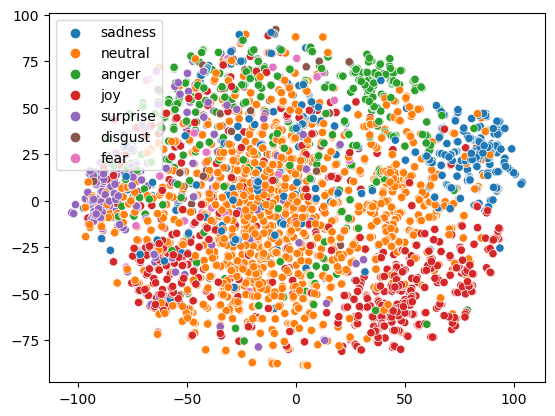

Epoch: 1 - Train Loss: 5.680568273088573


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.27s/it]


Cosine Similarity between mods: 0.40266536137123476
Mean norm audio tensor(0.3530)
Mean norm text tensor(0.6470)
General - KNN F1: 0.6411565087512073 Acc: 0.6471046481433393
Iemocap - KNN F1: 0.7789831477626628 Acc: 0.7767929089443997
Iemocap - KNN F1 - Only Audio: 0.47178725608193633
Meld - KNN F1: 0.5691548089868228 Acc: 0.5854406130268199
Meld - KNN F1 - Only Audio: 0.3209474006335596
Iemocap - KNN F1 (macro): 0.5191051195998452
Meld - KNN F1 (macro): 0.39135893589709064


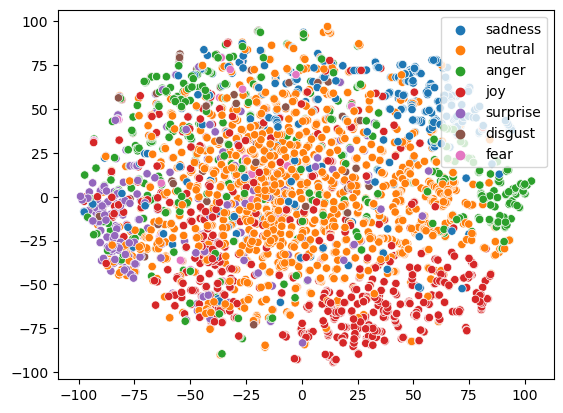

Epoch: 2 - Train Loss: 5.347493336264011


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.27s/it]


Cosine Similarity between mods: 0.41053393573706504
Mean norm audio tensor(0.3191)
Mean norm text tensor(0.6809)
General - KNN F1: 0.6479373099789466 Acc: 0.6530771228252402
Iemocap - KNN F1: 0.778483815134701 Acc: 0.7751813053988719
Iemocap - KNN F1 - Only Audio: 0.4727820377435134
Meld - KNN F1: 0.579896183100745 Acc: 0.5950191570881226
Meld - KNN F1 - Only Audio: 0.29972135819437024
Iemocap - KNN F1 (macro): 0.6235545255504115
Meld - KNN F1 (macro): 0.3996406528356057


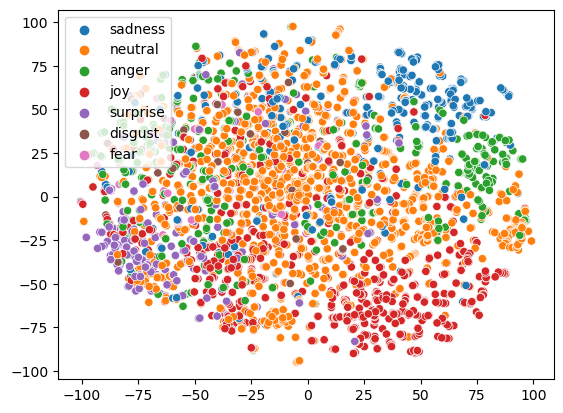

Epoch: 3 - Train Loss: 5.186707711852757


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]


Cosine Similarity between mods: 0.42449993964635807
Mean norm audio tensor(0.3078)
Mean norm text tensor(0.6922)
General - KNN F1: 0.6458196719050228 Acc: 0.6517787587639574
Iemocap - KNN F1: 0.7729581336781874 Acc: 0.7703464947622884
Iemocap - KNN F1 - Only Audio: 0.5075984917317893
Meld - KNN F1: 0.5791610587156916 Acc: 0.5954022988505747
Meld - KNN F1 - Only Audio: 0.3148553050665753
Iemocap - KNN F1 (macro): 0.616949504544875
Meld - KNN F1 (macro): 0.3959822036322856


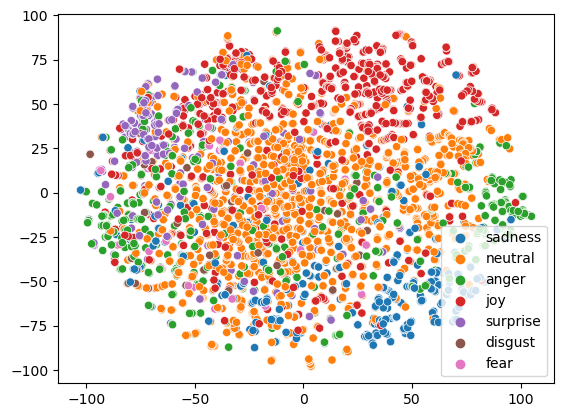

Epoch: 4 - Train Loss: 5.0661135479412245


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]


Cosine Similarity between mods: 0.4309964275335343
Mean norm audio tensor(0.2998)
Mean norm text tensor(0.7002)
General - KNN F1: 0.6387549413746699 Acc: 0.6447675928330304
Iemocap - KNN F1: 0.7640656800471324 Acc: 0.7606768734891217
Iemocap - KNN F1 - Only Audio: 0.5042114474371038
Meld - KNN F1: 0.5742834006003917 Acc: 0.5896551724137931
Meld - KNN F1 - Only Audio: 0.35200167350695544
Iemocap - KNN F1 (macro): 0.5074147797295675
Meld - KNN F1 (macro): 0.4032356327859528


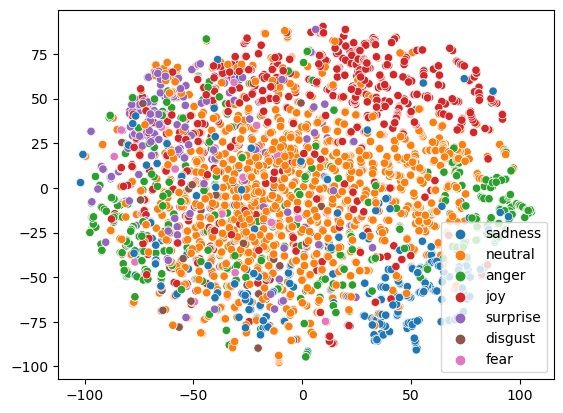

Epoch: 5 - Train Loss: 4.968138044914313


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it]


Cosine Similarity between mods: 0.43105174113917244
Mean norm audio tensor(0.2838)
Mean norm text tensor(0.7162)
General - KNN F1: 0.6403366003233179 Acc: 0.6486626850168787
Iemocap - KNN F1: 0.774572400186151 Acc: 0.7711522965350524
Iemocap - KNN F1 - Only Audio: 0.49363412273646023
Meld - KNN F1: 0.5710090543388004 Acc: 0.5904214559386973
Meld - KNN F1 - Only Audio: 0.34419345325683
Iemocap - KNN F1 (macro): 0.6190134014435105
Meld - KNN F1 (macro): 0.3883527078893634


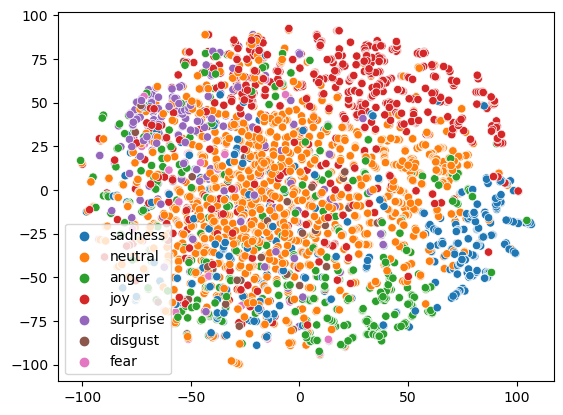

Epoch: 6 - Train Loss: 4.884568539340939


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it]


Cosine Similarity between mods: 0.43535514758240557
Mean norm audio tensor(0.2600)
Mean norm text tensor(0.7400)
General - KNN F1: 0.639424611991545 Acc: 0.6463256297065697
Iemocap - KNN F1: 0.7618396729916891 Acc: 0.75825946817083
Iemocap - KNN F1 - Only Audio: 0.5089116628403516
Meld - KNN F1: 0.574932264742953 Acc: 0.593103448275862
Meld - KNN F1 - Only Audio: 0.3515832869675705
Iemocap - KNN F1 (macro): 0.607390652522011
Meld - KNN F1 (macro): 0.3917372153854311


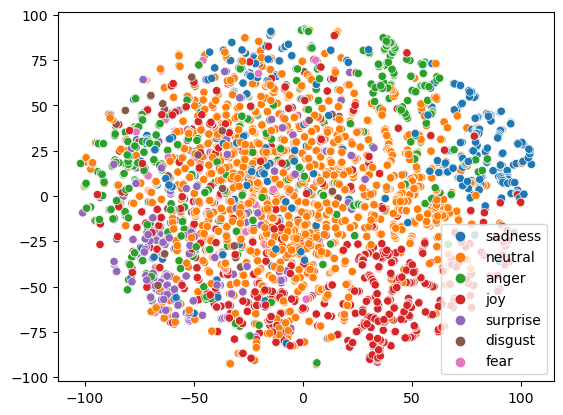

Epoch: 7 - Train Loss: 4.8134168270414905


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]


Cosine Similarity between mods: 0.4361643111417895
Mean norm audio tensor(0.2373)
Mean norm text tensor(0.7627)
General - KNN F1: 0.6376580083482591 Acc: 0.6468449753310829
Iemocap - KNN F1: 0.7623101604136535 Acc: 0.75825946817083
Iemocap - KNN F1 - Only Audio: 0.5075486362423165
Meld - KNN F1: 0.5705023572504851 Acc: 0.5938697318007663
Meld - KNN F1 - Only Audio: 0.35660358163905115
Iemocap - KNN F1 (macro): 0.6112746550059334
Meld - KNN F1 (macro): 0.3864751181454561


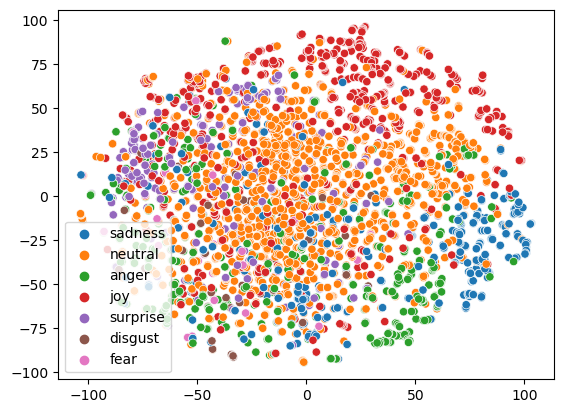

Epoch: 8 - Train Loss: 4.746133492056248


100%|█████████████████████████████████████████████| 4/4 [00:11<00:00,  2.78s/it]


Cosine Similarity between mods: 0.436965161811157
Mean norm audio tensor(0.2195)
Mean norm text tensor(0.7805)
General - KNN F1: 0.6376002172440335 Acc: 0.6473643209555959
Iemocap - KNN F1: 0.7703812876893797 Acc: 0.7663174858984689
Iemocap - KNN F1 - Only Audio: 0.5008341724318425
Meld - KNN F1: 0.566731198654509 Acc: 0.5908045977011495
Meld - KNN F1 - Only Audio: 0.3727022059579716
Iemocap - KNN F1 (macro): 0.5126024797418307
Meld - KNN F1 (macro): 0.38863487918057726


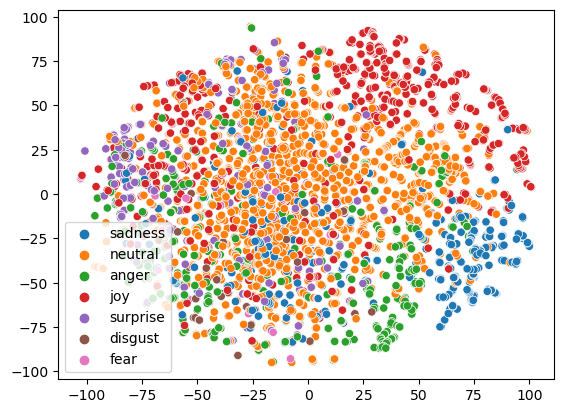

Epoch: 9 - Train Loss: 4.686788407047238


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.69s/it]


Cosine Similarity between mods: 0.4342837357205312
Mean norm audio tensor(0.2113)
Mean norm text tensor(0.7887)
General - KNN F1: 0.6406881840744345 Acc: 0.649701376265905
Iemocap - KNN F1: 0.7587566077590501 Acc: 0.7534246575342466
Iemocap - KNN F1 - Only Audio: 0.5024907491781896
Meld - KNN F1: 0.5777359216186988 Acc: 0.6003831417624521
Meld - KNN F1 - Only Audio: 0.3581278192075826
Iemocap - KNN F1 (macro): 0.505368386186238
Meld - KNN F1 (macro): 0.40028511689906393


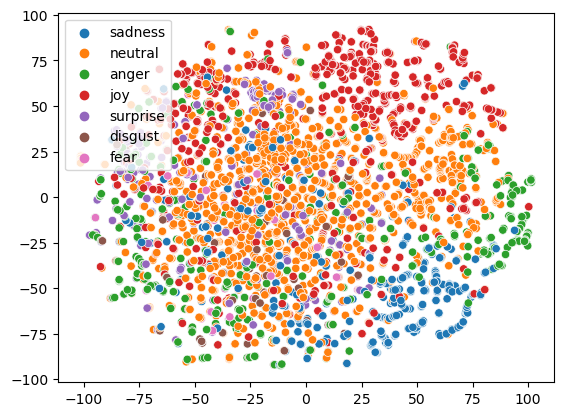

Epoch: 10 - Train Loss: 4.627651526864651


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]


Cosine Similarity between mods: 0.4355006350445704
Mean norm audio tensor(0.1992)
Mean norm text tensor(0.8008)
General - KNN F1: 0.628261541196371 Acc: 0.6382757725266165
Iemocap - KNN F1: 0.7619655807635437 Acc: 0.7558420628525383
Iemocap - KNN F1 - Only Audio: 0.5157061702729856
Meld - KNN F1: 0.5564513089411167 Acc: 0.5823754789272031
Meld - KNN F1 - Only Audio: 0.3661332719997178
Iemocap - KNN F1 (macro): 0.5089045961789821
Meld - KNN F1 (macro): 0.37340882637040373


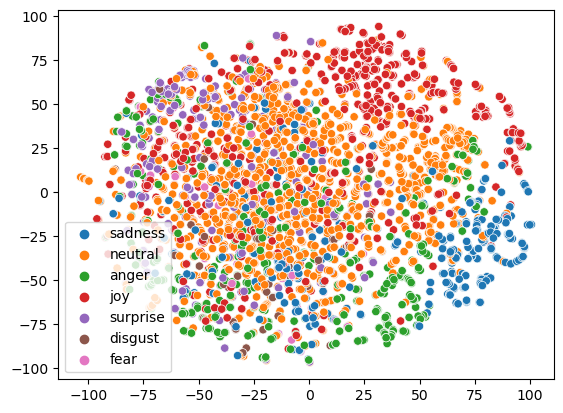

Epoch: 11 - Train Loss: 4.576451035727442


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.30s/it]


Cosine Similarity between mods: 0.43519070451211944
Mean norm audio tensor(0.1937)
Mean norm text tensor(0.8063)
General - KNN F1: 0.6293629422385018 Acc: 0.6393144637756427
Iemocap - KNN F1: 0.7601241913166934 Acc: 0.7534246575342466
Iemocap - KNN F1 - Only Audio: 0.5022351189114063
Meld - KNN F1: 0.5600792200557397 Acc: 0.5850574712643678
Meld - KNN F1 - Only Audio: 0.3681265947540119
Iemocap - KNN F1 (macro): 0.5053299836547412
Meld - KNN F1 (macro): 0.38073303267766445


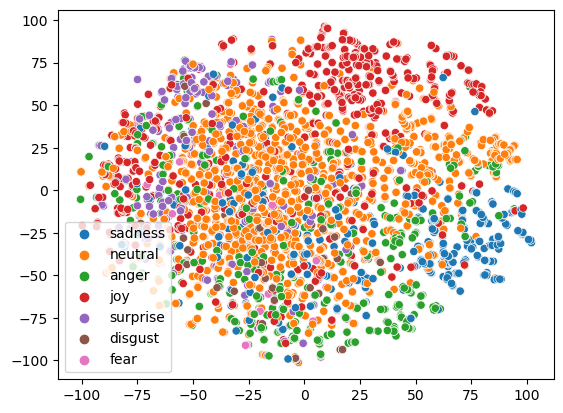

Epoch: 12 - Train Loss: 4.524411771149762


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]


Cosine Similarity between mods: 0.4323255469105021
Mean norm audio tensor(0.1878)
Mean norm text tensor(0.8122)
General - KNN F1: 0.6351858215085573 Acc: 0.6447675928330304
Iemocap - KNN F1: 0.7682975264728016 Acc: 0.7622884770346495
Iemocap - KNN F1 - Only Audio: 0.5184623112131616
Meld - KNN F1: 0.5646987818295814 Acc: 0.5888888888888889
Meld - KNN F1 - Only Audio: 0.37690130592729715
Iemocap - KNN F1 (macro): 0.5126451751075162
Meld - KNN F1 (macro): 0.3852695134438298


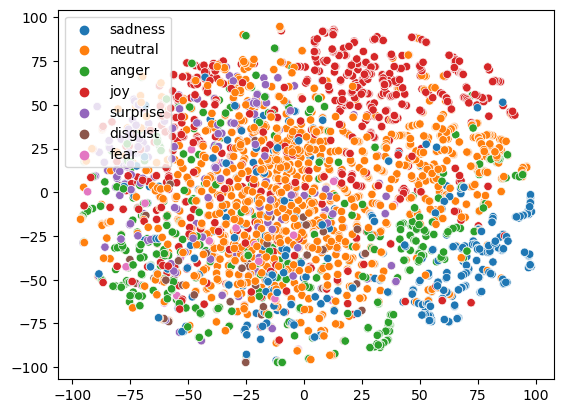

Epoch: 13 - Train Loss: 4.471302062009288


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.31s/it]


Cosine Similarity between mods: 0.4289871251480947
Mean norm audio tensor(0.1877)
Mean norm text tensor(0.8123)
General - KNN F1: 0.630715929586304 Acc: 0.640872500649182
Iemocap - KNN F1: 0.7561661753844324 Acc: 0.750201450443191
Iemocap - KNN F1 - Only Audio: 0.5032502279452393
Meld - KNN F1: 0.5672796553585971 Acc: 0.5888888888888889
Meld - KNN F1 - Only Audio: 0.3759802542794487
Iemocap - KNN F1 (macro): 0.5015778792802592
Meld - KNN F1 (macro): 0.3968301887606384


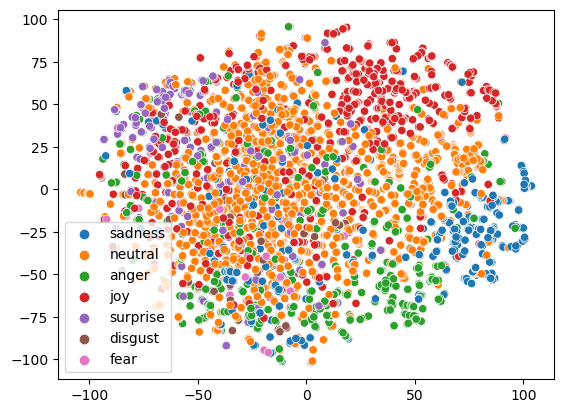

Epoch: 14 - Train Loss: 4.427783430150125


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.45s/it]


Cosine Similarity between mods: 0.4303970832200646
Mean norm audio tensor(0.1806)
Mean norm text tensor(0.8194)
General - KNN F1: 0.6308173676565925 Acc: 0.6429498831472344
Iemocap - KNN F1: 0.7637958146174862 Acc: 0.7574536663980661
Iemocap - KNN F1 - Only Audio: 0.5034182724569977
Meld - KNN F1: 0.5620745075733751 Acc: 0.5885057471264368
Meld - KNN F1 - Only Audio: 0.3738820318197492
Iemocap - KNN F1 (macro): 0.6138749216493131
Meld - KNN F1 (macro): 0.3771575545208635


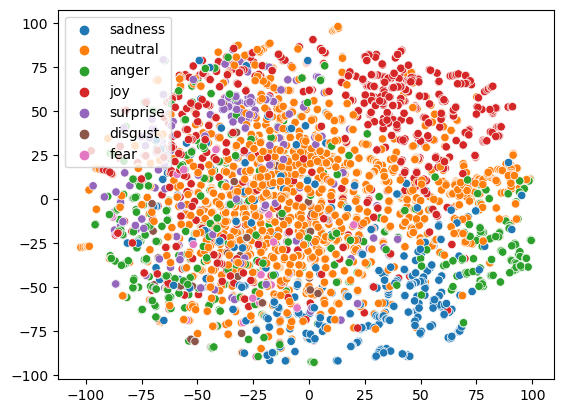

Epoch: 15 - Train Loss: 4.37960074855163


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.65s/it]


Cosine Similarity between mods: 0.4291503478322392
Mean norm audio tensor(0.1814)
Mean norm text tensor(0.8186)
General - KNN F1: 0.63187469335167 Acc: 0.6439885743962607
Iemocap - KNN F1: 0.7550061876060682 Acc: 0.7485898468976632
Iemocap - KNN F1 - Only Audio: 0.5228855754294593
Meld - KNN F1: 0.5658657461465731 Acc: 0.5942528735632184
Meld - KNN F1 - Only Audio: 0.38271968443899723
Iemocap - KNN F1 (macro): 0.5039161340896627
Meld - KNN F1 (macro): 0.3821229128426365


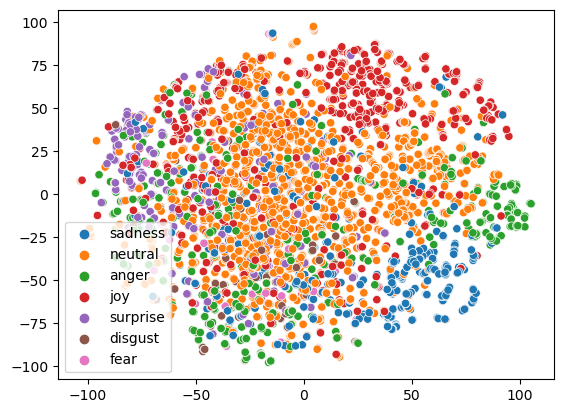

Epoch: 16 - Train Loss: 4.341432128332357


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.55s/it]


Cosine Similarity between mods: 0.4256544804083964
Mean norm audio tensor(0.1732)
Mean norm text tensor(0.8268)
General - KNN F1: 0.6289223415189235 Acc: 0.6421708647104648
Iemocap - KNN F1: 0.7568432011713664 Acc: 0.7493956486704271
Iemocap - KNN F1 - Only Audio: 0.5095736583731887
Meld - KNN F1: 0.55855247275735 Acc: 0.5911877394636015
Meld - KNN F1 - Only Audio: 0.37211397926918627
Iemocap - KNN F1 (macro): 0.5060300480745318
Meld - KNN F1 (macro): 0.3750576119473917


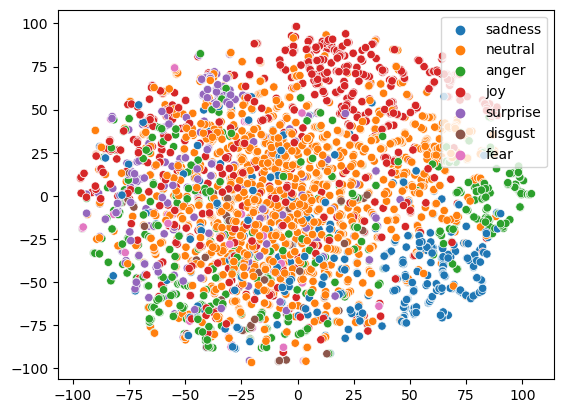

Epoch: 17 - Train Loss: 4.300406038233664


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.56s/it]


Cosine Similarity between mods: 0.42176956339211813
Mean norm audio tensor(0.1749)
Mean norm text tensor(0.8251)
General - KNN F1: 0.6164025225120331 Acc: 0.6291872240976369
Iemocap - KNN F1: 0.7347774902669517 Acc: 0.7276390008058018
Iemocap - KNN F1 - Only Audio: 0.5133633142717461
Meld - KNN F1: 0.5541187385705673 Acc: 0.5823754789272031
Meld - KNN F1 - Only Audio: 0.3814129702443245
Iemocap - KNN F1 (macro): 0.4929906713639674
Meld - KNN F1 (macro): 0.37334134114611245


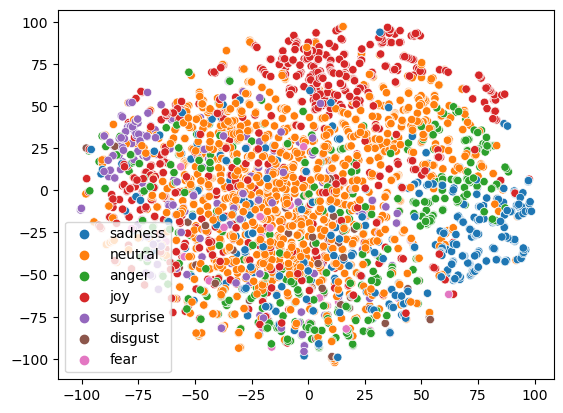

Epoch: 18 - Train Loss: 4.266684173482709


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.59s/it]


Cosine Similarity between mods: 0.4193729627476021
Mean norm audio tensor(0.1706)
Mean norm text tensor(0.8294)
General - KNN F1: 0.6198465410255374 Acc: 0.631524279407946
Iemocap - KNN F1: 0.7449742339329909 Acc: 0.7381144238517324
Iemocap - KNN F1 - Only Audio: 0.5109253404595818
Meld - KNN F1: 0.5549152271736647 Acc: 0.5808429118773947
Meld - KNN F1 - Only Audio: 0.3740601613888265
Iemocap - KNN F1 (macro): 0.5989446590659313
Meld - KNN F1 (macro): 0.37540929970008735


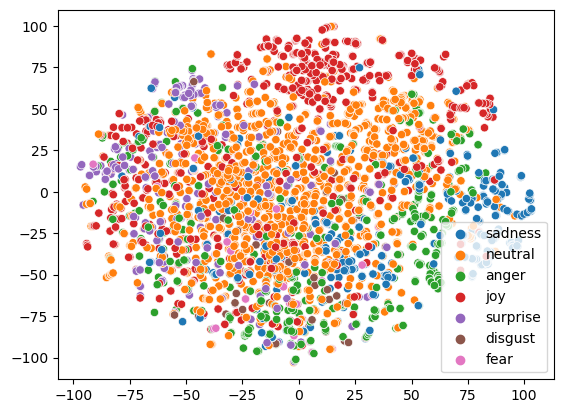

Epoch: 19 - Train Loss: 4.236909642683721


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.44s/it]


Cosine Similarity between mods: 0.41667374596289924
Mean norm audio tensor(0.1662)
Mean norm text tensor(0.8338)
General - KNN F1: 0.6176836709334882 Acc: 0.6297065697221501
Iemocap - KNN F1: 0.7505021757866478 Acc: 0.7437550362610797
Iemocap - KNN F1 - Only Audio: 0.5045445056647994
Meld - KNN F1: 0.5485783625280042 Acc: 0.5754789272030651
Meld - KNN F1 - Only Audio: 0.36870088564582115
Iemocap - KNN F1 (macro): 0.6007392910721413
Meld - KNN F1 (macro): 0.37339699801271137


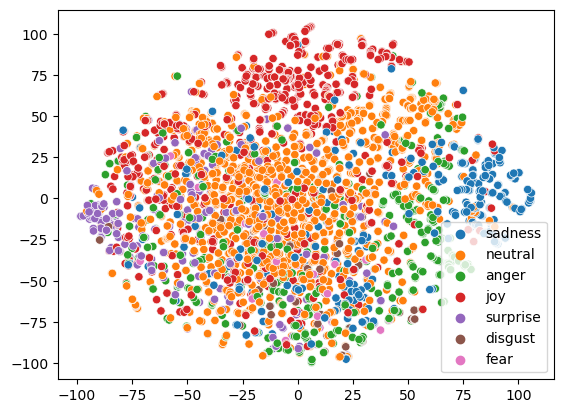

Epoch: 20 - Train Loss: 4.2025392329798335


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]


Cosine Similarity between mods: 0.4129242759591665
Mean norm audio tensor(0.1668)
Mean norm text tensor(0.8332)
General - KNN F1: 0.6186889811749864 Acc: 0.6320436250324591
Iemocap - KNN F1: 0.754885628776124 Acc: 0.7477840451248993
Iemocap - KNN F1 - Only Audio: 0.511767038373678
Meld - KNN F1: 0.5462583150572226 Acc: 0.5770114942528736
Meld - KNN F1 - Only Audio: 0.3659716963192876
Iemocap - KNN F1 (macro): 0.6056549694272381
Meld - KNN F1 (macro): 0.36704381209703696


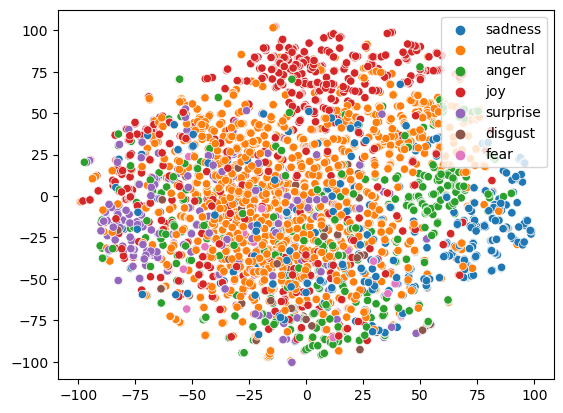

Epoch: 21 - Train Loss: 4.16958374681726


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.46s/it]


Cosine Similarity between mods: 0.41129669292472737
Mean norm audio tensor(0.1707)
Mean norm text tensor(0.8293)
General - KNN F1: 0.6174365153165068 Acc: 0.6289275512853805
Iemocap - KNN F1: 0.7478037750541496 Acc: 0.7397260273972602
Iemocap - KNN F1 - Only Audio: 0.5122718657584613
Meld - KNN F1: 0.5497884230964534 Acc: 0.5762452107279693
Meld - KNN F1 - Only Audio: 0.38564898561661165
Iemocap - KNN F1 (macro): 0.49997233865286655
Meld - KNN F1 (macro): 0.3698361708672216


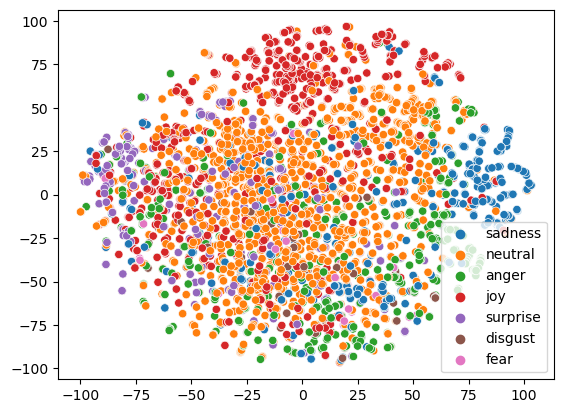

Epoch: 22 - Train Loss: 4.13685555162683


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]


Cosine Similarity between mods: 0.4054978696812719
Mean norm audio tensor(0.1719)
Mean norm text tensor(0.8281)
General - KNN F1: 0.6204950262857483 Acc: 0.6323032978447156
Iemocap - KNN F1: 0.7540556474748347 Acc: 0.7469782433521354
Iemocap - KNN F1 - Only Audio: 0.5175759357987257
Meld - KNN F1: 0.550556413684913 Acc: 0.5777777777777777
Meld - KNN F1 - Only Audio: 0.38581490442285016
Iemocap - KNN F1 (macro): 0.49916719652395
Meld - KNN F1 (macro): 0.375792404434024


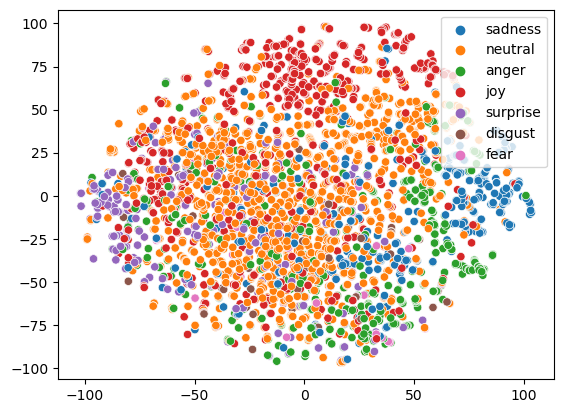

Epoch: 23 - Train Loss: 4.108839359958615


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.37s/it]


Cosine Similarity between mods: 0.40414196520587187
Mean norm audio tensor(0.1826)
Mean norm text tensor(0.8174)
General - KNN F1: 0.6113482063774807 Acc: 0.6255518047260452
Iemocap - KNN F1: 0.7448255985727297 Acc: 0.7373086220789685
Iemocap - KNN F1 - Only Audio: 0.501019293378374
Meld - KNN F1: 0.5414055694837842 Acc: 0.5724137931034483
Meld - KNN F1 - Only Audio: 0.38685389937763304
Iemocap - KNN F1 (macro): 0.49752159820868197
Meld - KNN F1 (macro): 0.36132291045753734


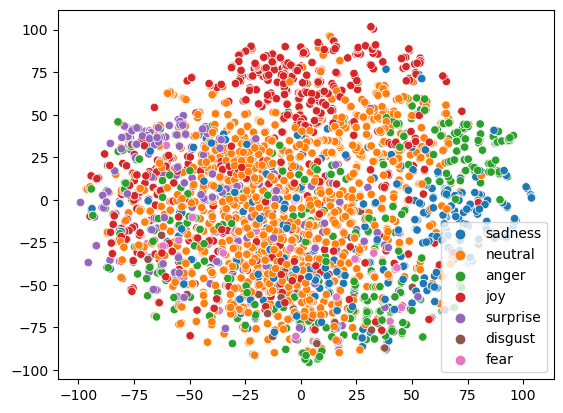

Epoch: 24 - Train Loss: 4.086078133203287


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.29s/it]


Cosine Similarity between mods: 0.3992732584677681
Mean norm audio tensor(0.1844)
Mean norm text tensor(0.8156)
General - KNN F1: 0.6067594069781281 Acc: 0.6219163853544534
Iemocap - KNN F1: 0.7364823939182816 Acc: 0.7292506043513296
Iemocap - KNN F1 - Only Audio: 0.4925321981818496
Meld - KNN F1: 0.5375287925681381 Acc: 0.5708812260536399
Meld - KNN F1 - Only Audio: 0.37375104914089813
Iemocap - KNN F1 (macro): 0.5944592632059956
Meld - KNN F1 (macro): 0.3427128149750106


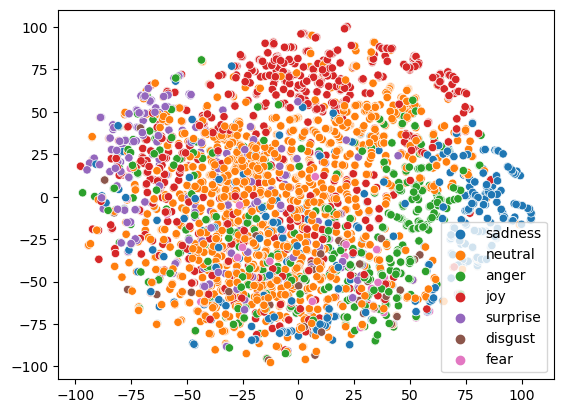

Epoch: 25 - Train Loss: 4.057952355494542


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]


Cosine Similarity between mods: 0.3946990610190535
Mean norm audio tensor(0.1813)
Mean norm text tensor(0.8187)
General - KNN F1: 0.6182003640261593 Acc: 0.6304855881589198
Iemocap - KNN F1: 0.7502912393958291 Acc: 0.7445608380338437
Iemocap - KNN F1 - Only Audio: 0.5114089386447376
Meld - KNN F1: 0.5500330292456589 Acc: 0.5762452107279693
Meld - KNN F1 - Only Audio: 0.3833945305432304
Iemocap - KNN F1 (macro): 0.6024087484800518
Meld - KNN F1 (macro): 0.373286170603592


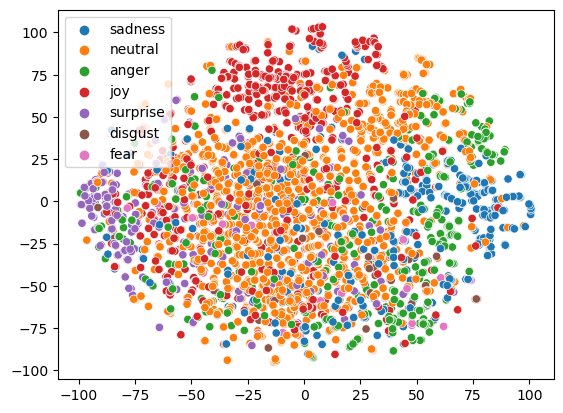

Epoch: 26 - Train Loss: 4.032955287832074


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.36s/it]


Cosine Similarity between mods: 0.39507294295515777
Mean norm audio tensor(0.1885)
Mean norm text tensor(0.8115)
General - KNN F1: 0.6125800302603037 Acc: 0.6258114775383017
Iemocap - KNN F1: 0.749571165000718 Acc: 0.7421434327155519
Iemocap - KNN F1 - Only Audio: 0.4940323386057273
Meld - KNN F1: 0.5415191020241631 Acc: 0.5704980842911878
Meld - KNN F1 - Only Audio: 0.37148857618331005
Iemocap - KNN F1 (macro): 0.5003385726343317
Meld - KNN F1 (macro): 0.36553364922071563


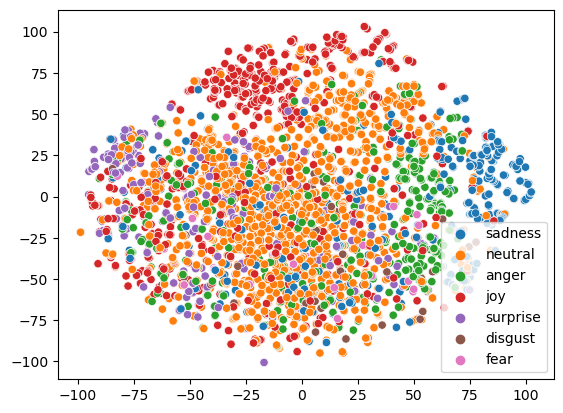

Epoch: 27 - Train Loss: 4.010968113367537


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.26s/it]


Cosine Similarity between mods: 0.39522475423641995
Mean norm audio tensor(0.1894)
Mean norm text tensor(0.8106)
General - KNN F1: 0.6135373290196992 Acc: 0.6273695144118411
Iemocap - KNN F1: 0.7398174614276307 Acc: 0.7332796132151491
Iemocap - KNN F1 - Only Audio: 0.5081041515332687
Meld - KNN F1: 0.5462047045766695 Acc: 0.5770114942528736
Meld - KNN F1 - Only Audio: 0.3736380931956018
Iemocap - KNN F1 (macro): 0.4940033100883124
Meld - KNN F1 (macro): 0.3687434439138359


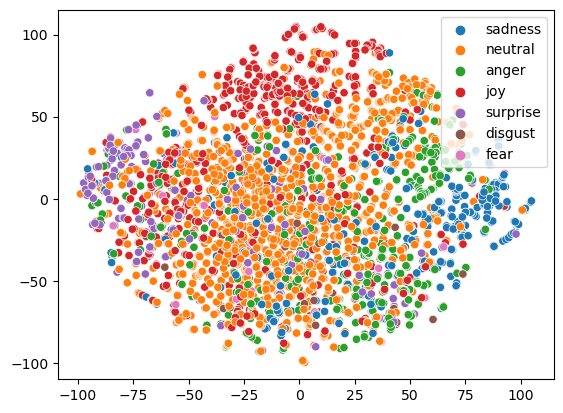

Epoch: 28 - Train Loss: 3.983685812063977


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.29s/it]


Cosine Similarity between mods: 0.39014437389943357
Mean norm audio tensor(0.1929)
Mean norm text tensor(0.8071)
General - KNN F1: 0.6120015668967258 Acc: 0.6247727862892755
Iemocap - KNN F1: 0.7444573584947866 Acc: 0.7389202256244963
Iemocap - KNN F1 - Only Audio: 0.4868282711717539
Meld - KNN F1: 0.542461388342068 Acc: 0.5704980842911878
Meld - KNN F1 - Only Audio: 0.38545183701553754
Iemocap - KNN F1 (macro): 0.5983905506092476
Meld - KNN F1 (macro): 0.36431228172177443


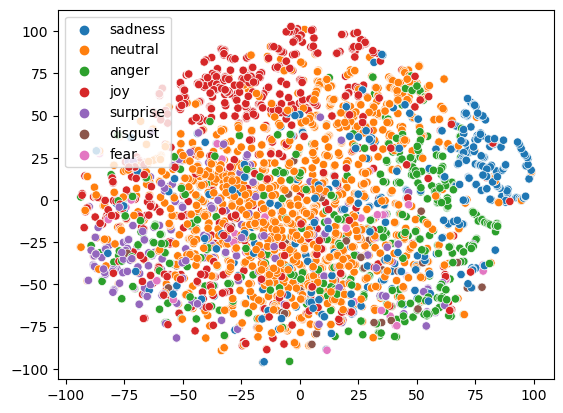

Epoch: 29 - Train Loss: 3.963538235267707


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]


Cosine Similarity between mods: 0.3899728066269313
Mean norm audio tensor(0.2039)
Mean norm text tensor(0.7961)
General - KNN F1: 0.6162322603120377 Acc: 0.6302259153466632
Iemocap - KNN F1: 0.7373709792092138 Acc: 0.7292506043513296
Iemocap - KNN F1 - Only Audio: 0.5243868576369456
Meld - KNN F1: 0.5537167085107575 Acc: 0.5831417624521072
Meld - KNN F1 - Only Audio: 0.37377567598439376
Iemocap - KNN F1 (macro): 0.59332020317939
Meld - KNN F1 (macro): 0.3674391828803937


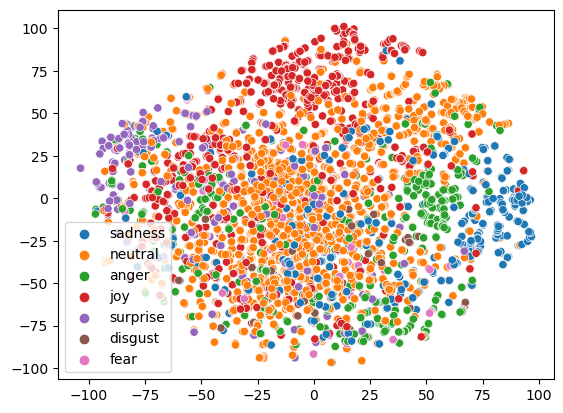

Epoch: 30 - Train Loss: 3.941575217036019


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.31s/it]


Cosine Similarity between mods: 0.3890542837899247
Mean norm audio tensor(0.1977)
Mean norm text tensor(0.8023)
General - KNN F1: 0.6201509064423475 Acc: 0.6351596987795378
Iemocap - KNN F1: 0.7482832278911916 Acc: 0.741337630942788
Iemocap - KNN F1 - Only Audio: 0.5081214979208768
Meld - KNN F1: 0.5521375972251591 Acc: 0.5846743295019157
Meld - KNN F1 - Only Audio: 0.3847890536634675
Iemocap - KNN F1 (macro): 0.4992325402905091
Meld - KNN F1 (macro): 0.3624311358241425


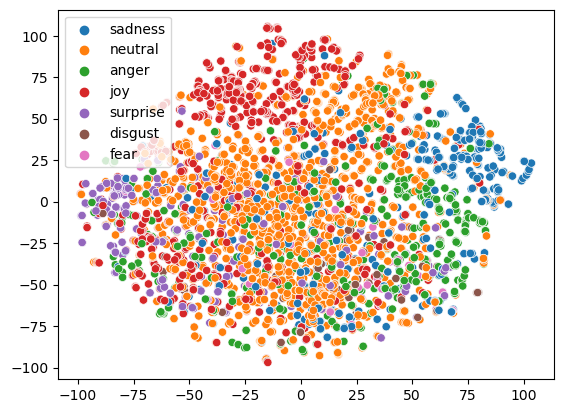

Epoch: 31 - Train Loss: 3.921519532667852


 48%|████████████████████                      | 54/113 [01:20<01:27,  1.48s/it]


KeyboardInterrupt: 

In [66]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_13'
!mkdir -p {PATH_TO_SAVE}
supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    rate=0.1,
)

# Grid search best temperatures
# Try to only fine tune on evaluation datasets
#supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

supcon_model.to(0)

scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

scheduler_epochs = 5
opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5, betas=(0.9, 0.98), eps=1e-8)
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.8, total_iters=10, last_epoch=- 1, verbose=False)
#scheduler = Scheduler(opt, 768, 600)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []
    was = []
    wts = []
    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        batch = df_train.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))
        y_text_senti = torch.Tensor(lab_encoder_senti.transform(only_text["sentiment_label"]))
        
        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()

        mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

        audio_input = {
            "features": mfccs.float().to(0),
            "attn_masks": att.float().to(0),
        }

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))
        y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))
        
        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()].reset_index(drop=True)
        
        mult_not_na_idx = mult[mult["label"].notna()].index
        #batch_not_na_idx = batch[batch["label"].notna()].index
        #mult_na_idx = mult[mult["label"].isna()].index
        
        y_mult = torch.Tensor(lab_encoder.transform(mult.iloc[mult_not_na_idx]["label"]))
        
        y_mult_senti = torch.Tensor(lab_encoder_senti.transform(mult["sentiment_label"]))
        
        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]
        
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)
        
        # Augment Text Context
        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]
        
        for k, s in enumerate(sentences):
            if '[BFR]' in s:
                pass
            else:
                sentences[k] = '[BFR] ' + sentences[k]

            if '[AFT]' in s:
                pass
            else:
                sentences[k] = sentences[k] + ' [AFT]'
                
        for k, s in enumerate(sentences_mult):
            if '[BFR]' in s:
                pass
            else:
                sentences_mult[k] = '[BFR] ' + sentences_mult[k]

            if '[AFT]' in s:
                pass
            else:
                sentences_mult[k] = sentences_mult[k] + ' [AFT]'
                
        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}
        
        target = torch.cat([y_text, y_audio, y_mult]).long().cuda()
        target_senti = torch.cat([y_text_senti, y_audio_senti, y_mult_senti]).long().cuda()
        
        x = [sentences, audio_input, multimodal]
        
        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult_text_norm = F.normalize(x_mult_text, dim=-1)
                x_mult_audio_norm = F.normalize(x_mult_audio, dim=-1)
                
                #weights = torch.stack([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                wa = torch.norm(x_mult_audio, dim=-1).detach()
                wt = torch.norm(x_mult_text, dim=-1).detach()
                weights = torch.cat([wa, wt], dim=0).detach()
                was.append(wa.cpu())
                wts.append(wt.cpu())

                # Augument modality
                augs = random.choices(
                    population=[0, 1, 2],
                    weights=[0.8, 0.1, 0.1],
                    k=len(x_mult_text)
                )
                
                x_mult = torch.stack([F.normalize(x_mult_text + x_mult_audio, dim=-1), 
                                      x_mult_text_norm, 
                                     x_mult_audio_norm], dim=1)
                
                x_mult = x_mult[list(range(len(augs))), augs, :] 
                
                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
                
                # Add weighted contrastive loss
                #x_mult_text = x_mult_text_norm.unsqueeze(dim=1)
                #x_mult_audio = x_mult_audio_norm.unsqueeze(dim=1)
                #mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                out_x, out_x_wide = None, None
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                elif x[1] is not None:
                    out_x = torch.cat([out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                    out_x_lab = torch.cat([out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                    out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                else:
                    out_x = x_mult.unsqueeze(dim=1)
                    out_x_lab = x_mult[mult_not_na_idx] #.unsqueeze(dim=1)
                    out_x_wide = x_mult_wide[mult_not_na_idx]
                
                # fera ta
                
                loss = 0.5 * (0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)) \
                        + 0.5 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.1, weights=None)
                #loss = 0.5 * (0.5 * supcon_loss(out_x_lab, labels=target) + 0.5 * supcon_loss_senti(out_x, labels=target_senti)) + 0.5 * supcon_loss_intra(mult, weights=weights) 
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = 0.9 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.1 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) #+ 0.8 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.8, weights=None)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 30.0)
        scaler.step(opt)
        scaler.update()
        #scheduler.step()
        
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del x_mult
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()
    scheduler.step()
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    #supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    wide_audio = []
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_batch = test_df_erc.iloc[batch_indices[0]]

            audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
            mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

            sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

            for k, s in enumerate(sentences_mult):
                if '[BFR]' in s:
                    pass
                else:
                    sentences_mult[k] = '[BFR] ' + sentences_mult[k]

                if '[AFT]' in s:
                    pass
                else:
                    sentences_mult[k] = sentences_mult[k] + ' [AFT]'
                
            multimodal = {'sentences': sentences_mult, 
                          'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

            target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(F.normalize(out["x_mult_text_wide"], dim=-1), F.normalize(out["x_mult_audio_wide"], dim=-1))

            wide = np.array(out_x_wide.cpu())
            wide_audio.append(np.array(F.normalize(out["x_mult_audio_wide"], dim=-1).cpu()))
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    wide_audio = np.concatenate(wide_audio, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(test_df_erc)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    print(f'Cosine Similarity between mods: {css}')
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_f1_iemocap_audio = f1_score(targets_val[iemocap_idx], clf.predict(wide_audio)[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_f1_meld_audio = f1_score(targets_val[meld_idx], clf.predict(wide_audio)[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print("Mean norm audio", torch.cat(was).mean())
    print("Mean norm text", torch.cat(wts).mean())
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    print(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

    try:
        tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
        plt.show()
    
    except:
        pass
    
    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1
    
    #if e == scheduler_epochs: # Unfreeze text encoder
    #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
    #        param.requires_grad = True

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
        f.write(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
torch.cat(wts).mean()

In [ ]:
np.array(torch.Tensor(was).mean())

In [ ]:
list(weights.cpu().numpy())[8]

In [ ]:
sentences_mult[:8]

In [ ]:
len(multimodal["sentences"])

In [ ]:
sentences

In [ ]:
mult.head(20)["text"].tolist()

In [ ]:
"""
Cosine Similarity between mods: 0.6148036817116292
General - KNN F1: 0.652949920693673 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7621117618450867 Acc: 0.7558420628525383
Iemocap - KNN F1 - Only Audio: 0.48286032752145575
Meld - KNN F1: 0.6025222678926638 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6085758686292261
Meld - KNN F1 (macro): 0.41899567212117655

Epoch: 31 - Train Loss: 6.175596459077136
"""

## Eval

In [ ]:
ss

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [ ]:
gc.collect()

In [ ]:
#PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_5_layer_pivoting_to_speech_training'

In [ ]:
#torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model']
#torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_1.bin')['model']

In [ ]:
PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    rate=0.0,
).cuda()
supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_15.bin')['model'])

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_n_params(supcon_model)

In [ ]:
supcon_model.eval()

In [ ]:
import pickle

In [ ]:
supcon_model.train()
test = supcon_model([["I Hate you, i believe you are shit!", "You are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I love you, mate!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
supcon_model.train()
supcon_model.training = False
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.100.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I am very sad"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
torch.norm(test["x_text"][0, :])

In [ ]:
torch.norm(test["x_audio"][0, :])

In [ ]:
supcon_model.eval()
supcon_model.training = False
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.101.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I love my girlfriend, but she died"],audio_input, None])
    print(torch.dot(test["x_text"][0, :], test["x_audio"][0, :]))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I am sad"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["My dog was great, but he was also cute! Today he is dead"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=-1), F.normalize(test["x_audio"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I had a discussion with my mother", "I love my mother"],audio_input, None])
    print(torch.dot(test["x_text_wide"][0, :], test["x_audio_wide"][0, :]))
    print(torch.dot(test["x_text_wide"][1, :], test["x_audio_wide"][0, :]))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I just finished my PhD!!", "I finished my PhD, but I dont have a job"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_text_wide"][1, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.279.wav", "./audio/audio_emo/tess.woman.sad.59.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I did not pass in the final exam, i will kill myself"], audio_input, None])
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][1, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][1, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))

In [ ]:
test

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        activation[name] = output #.detach()
    return hook

In [ ]:
get_activation

In [ ]:
supcon_model

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        print(output.shape)
        activation[name] = output #.detach()
    return hook

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=False,
    rate=0.2,
).cuda()

supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_16.bin')['model'])

supcon_model.audio_proj.register_forward_hook(get_activation('audio_proj'))
output = supcon_model([["I had a discussion with my mother"],audio_input, None])
activation['audio_proj']

In [ ]:
m

In [ ]:
test["x_audio_wide"][0, :]

In [ ]:
test["x_audio"][0, :]

In [ ]:
test

In [ ]:
print(df_train[df_train["label"] == "sadness"]["path"].tolist())

In [ ]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [ ]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [ ]:
gc.collect()

In [ ]:
df_train_f =df_train

In [ ]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [ ]:
meld_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: True if "MELD" in x else False)].index

In [ ]:
iemocap_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: False if "MELD" in x else True)].index

In [ ]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[iemocap_train_idx].reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[meld_train_idx].reset_index(drop=True)
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_df_erc)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [ ]:
gc.collect()

In [ ]:
batch

In [ ]:
supcon_model.train()

proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
    with torch.no_grad():
        batch = train_df_erc.iloc[batch_indices[0]]

        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()]
        mult = mult[mult["label"].notna()]
        y_mult = torch.Tensor(lab_encoder.transform(mult["label"]))

        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]

        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

        target = y_mult

        x = [None, None, multimodal]

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #x_mult_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        proj_train.append(np.array(x_mult_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del x_mult_wide
        gc.collect()
        torch.cuda.empty_cache()
proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)

clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))

preds = []
targets = []
css = 0.0

for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_batch = test_df_erc.iloc[batch_indices[0]]

        audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

        target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #out_x_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)

preds = np.array(np.concatenate(preds, axis=0))

css = css / len(test_df_erc)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')

meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
plt.show()

In [ ]:
train_iemocap

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[meld_train_idx].mean(axis=0)
std_test = proj_train[meld_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[meld_train_idx]-mean_test)/std_test, np.array(targets_train[meld_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

from sklearn.metrics import classification_report

print(classification_report(targets_val[meld_idx], preds[meld_idx], digits=4))

In [ ]:
len(targets_val[iemocap_idx])

In [ ]:
set(lab_encoder.inverse_transform(np.array(targets_val[iemocap_idx], dtype=int)))


In [ ]:
df_iemocap_orig = pd.read_json("emotions.json").reset_index(drop=False)
df_iemocap_orig = pd.melt(df_iemocap_orig, id_vars=['index'], value_vars=['train', 'val', 'test']).dropna().drop(columns=["variable"]).rename(columns={"index":"id", "value": "orig_label"}).reset_index(drop=True)
df_iemocap_orig = df_iemocap_orig[df_iemocap_orig["orig_label"].notna() & (df_iemocap_orig["orig_label"] != "undecided")].reset_index(drop=True)
df_iemocap_orig

In [ ]:
def cleaning_shit(x):
    if "MELD" in x:
        return None
    x = x.replace("val/", "")
    x = x.replace("train/", "")
    x = x.replace("test/", "")
    l = len("/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/")
    return x[l:].replace(".wav", "")


In [ ]:
#train_df_erc_iemocap = train_df_erc[train_df_erc["path"].apply(lambda x: True if "IEMOCAP" in x else False)]
train_df_erc["id"] = train_df_erc["path"].apply(cleaning_shit)
train_df_erc_iemocap = train_df_erc.dropna()
train_df_erc_iemocap = train_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner").dropna()
train_df_erc_iemocap

In [ ]:
len(iemocap_train_idx)

In [ ]:
test_df_erc["id"] = test_df_erc["path"].apply(lambda x: x[len('/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/test/'):].replace(".wav", "")) 

In [ ]:
test_df_erc_iemocap = test_df_erc[test_df_erc["source"] == "iemocap"].reset_index(drop=True)
test_df_erc_iemocap

In [ ]:
test_df_erc_iemocap = test_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner")
test_df_erc_iemocap

In [ ]:
new_lab = LabelEncoder().fit(train_df_erc_iemocap["orig_label"])

In [ ]:
train_df_erc_iemocap["orig_label"].unique()

In [ ]:
test_df_erc_iemocap["orig_label"].unique()

In [ ]:
train_df_erc_iemocap

In [ ]:
test_df_erc_iemocap

In [ ]:
correct_labels_train = new_lab.transform(train_df_erc_iemocap["orig_label"])
correct_labels_test = new_lab.transform(test_df_erc_iemocap["orig_label"])

In [ ]:
correct_labels_train

In [ ]:
lab_encoder.classes_

In [ ]:
test_df_erc[test_df_erc["source"] == "iemocap"]["label"].value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train.mean(axis=0)
std_test = proj_train.std(axis=0)

#clf = MLPClassifier(hidden_layer_sizes=(768,), learning_rate="invscaling", solver="sgd", max_iter=5000, validation_fraction=0.2, nesterovs_momentum=False)
clf = LogisticRegression()
clf.fit((proj_train-mean_test)/std_test, np.array(targets_train, dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], preds[iemocap_idx], digits=4))

In [ ]:
general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])



In [ ]:
general_f1_iemocap

In [ ]:
general_f1_meld

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], list(map(lambda x: x if x != 1 else 6, preds[iemocap_idx])), digits=4))

## 